In [15]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding,Concatenate,Input,Bidirectional,LSTM,Dense,Dropout,GlobalAveragePooling1D,LayerNormalization,Layer
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import train_test_split
from itertools import chain

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
text_tokenizer = Tokenizer()

text_tokenizer.fit_on_texts(train_data['text'])

print('Vocabulary size:',len(text_tokenizer.word_index)+1)

Vocabulary size: 22701


In [4]:
train_sequences = text_tokenizer.texts_to_sequences(train_data['text'])
test_sequences = text_tokenizer.texts_to_sequences(test_data['text'])

train_sequences = np.array(pad_sequences(train_sequences, padding='post'))
test_sequences = np.array(pad_sequences(test_sequences, padding='post', maxlen=train_sequences.shape[1]))

In [5]:
print(train_sequences.shape, test_sequences.shape)

(7613, 33) (3263, 33)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(train_sequences, train_data['target'], test_size=0.2)

In [67]:
model = Sequential([
    Embedding(len(text_tokenizer.word_index)+1, 64),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy",optimizer='adam',metrics=[F1Score(threshold = 0.5)])

In [68]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=10, verbose=1, min_lr=0.0001)

history=model.fit(x_train,y_train,epochs=50,validation_data=(x_val,y_val),verbose=1,callbacks=[reduce_lr])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - f1_score: 0.4858 - loss: 0.5966 - val_f1_score: 0.7291 - val_loss: 0.4450 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - f1_score: 0.8719 - loss: 0.2789 - val_f1_score: 0.7135 - val_loss: 0.4651 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - f1_score: 0.9371 - loss: 0.1401 - val_f1_score: 0.7194 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.9782 - loss: 0.0632 - val_f1_score: 0.7020 - val_loss: 0.8630 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - f1_score: 0.9915 - loss: 0.0311 - val_f1_score: 0.7059 - val_loss: 0.7944 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.9949 - loss: 0.0224 - val_f1_score: 0.6725 - val_loss: 0.8675 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - f1_score: 0.9936 - loss: 0.

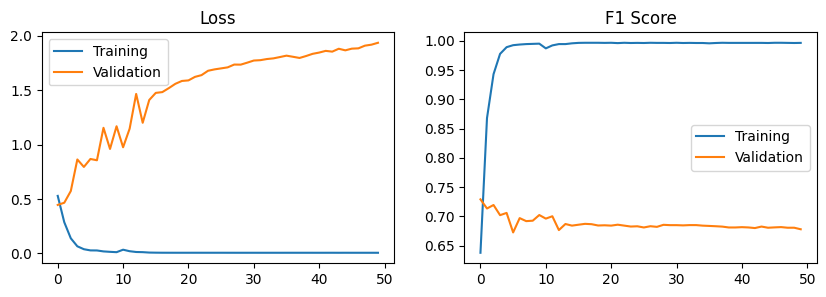

In [69]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('F1 Score')
plt.plot(history.history['f1_score'], label='Training')
plt.plot(history.history['val_f1_score'], label='Validation')
plt.legend()

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Text(0.5, 1.0, 'Training Data F1 Score: 1.0')

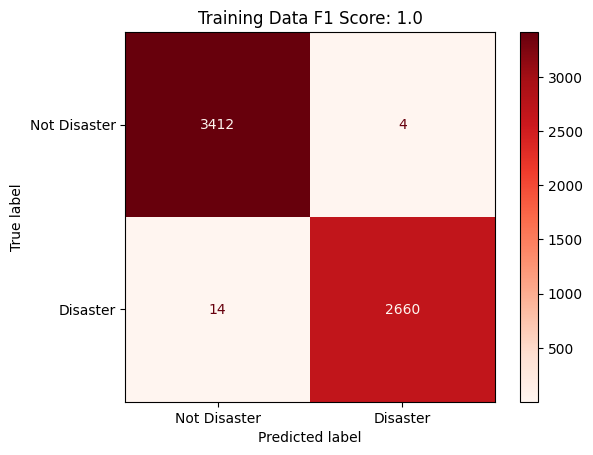

In [70]:
y_train_pred = model.predict(x_train)
y_train_pred = [int(p.item()>=0.5) for p in y_train_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Training Data F1 Score: '+str(f1_score.round(2)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Text(0.5, 1.0, 'Validation Data F1 Score: 0.68')

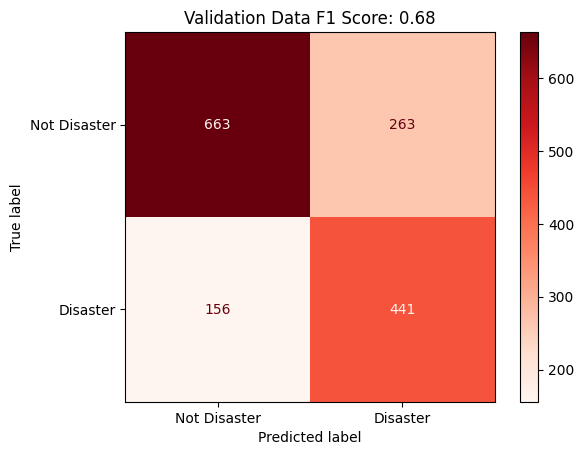

In [71]:
y_val_pred = model.predict(x_val)
y_val_pred = [int(p.item()>=0.5) for p in y_val_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Validation Data F1 Score: '+str(f1_score.round(2)))

In [ ]:
pred = model.predict(test_sequences)
y_pred = [(1 if p>=0.5 else 0) for p in pred]

submission = pd.DataFrame({'id':test_data['id'], 'target':y_pred})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [34]:
class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.2):
        super().__init__()
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_model * 2, activation='relu'),
            Dropout(dropout_rate),
            Dense(d_model)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.attn(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)
        return out2

def transformer_classifier(vocab_size, max_len, d_model, num_layers, num_heads, num_classes):
    input_ids = Input(shape=(max_len,))
    token_embeddings = Embedding(vocab_size, d_model)(input_ids)
    x = token_embeddings
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_ids, outputs=outputs)
    return model

model1 = transformer_classifier(vocab_size=len(text_tokenizer.word_index)+1, max_len=33, d_model=64, num_layers=2, num_heads=8, num_classes=1)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[F1Score(threshold = 0.5)])

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=10, verbose=1, min_lr=0.0001)
history1=model1.fit(x_train,y_train,epochs=50,validation_data=(x_val,y_val),verbose=1,callbacks=[reduce_lr])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - f1_score: 0.5002 - loss: 0.6536 - val_f1_score: 0.7589 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - f1_score: 0.8817 - loss: 0.2592 - val_f1_score: 0.7238 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - f1_score: 0.9650 - loss: 0.0956 - val_f1_score: 0.7070 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - f1_score: 0.9831 - loss: 0.0464 - val_f1_score: 0.7072 - val_loss: 1.0201 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - f1_score: 0.9892 - loss: 0.0323 - val_f1_score: 0.6968 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - f1_score: 0.9932 - loss: 0.0201 - val_f1_score: 0.6693 - val_loss: 1.0923 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - f1_score: 0.9943 - loss: 0

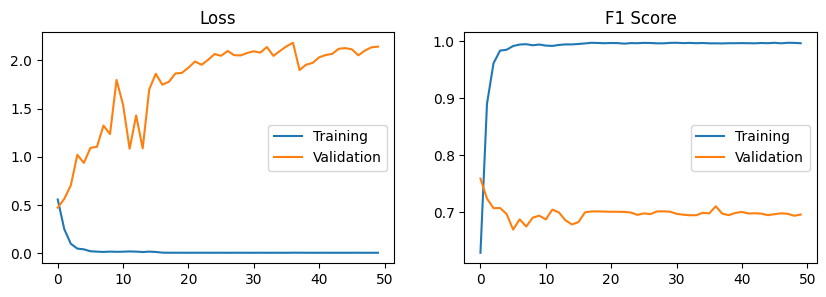

In [36]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('F1 Score')
plt.plot(history1.history['f1_score'], label='Training')
plt.plot(history1.history['val_f1_score'], label='Validation')
plt.legend()

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


Text(0.5, 1.0, 'Training Data F1 Score: 1.0')

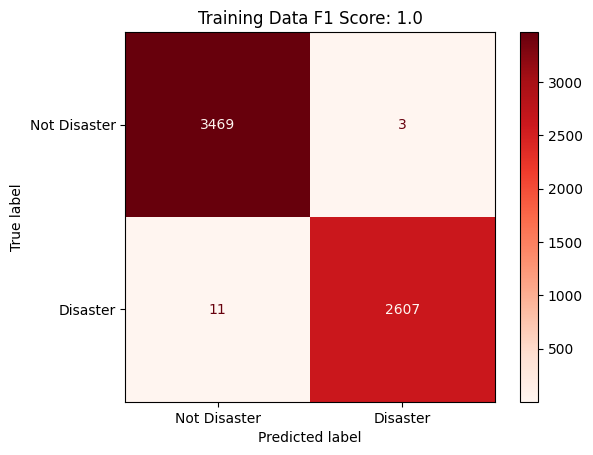

In [37]:
y_train_pred = model1.predict(x_train)
y_train_pred = [int(p.item()>=0.5) for p in y_train_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Training Data F1 Score: '+str(f1_score.round(2)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Text(0.5, 1.0, 'Validation Data F1 Score: 0.7')

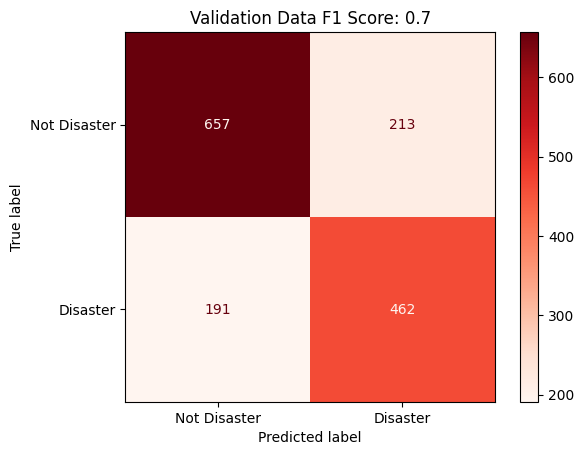

In [38]:
y_val_pred = model1.predict(x_val)
y_val_pred = [int(p.item()>=0.5) for p in y_val_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Validation Data F1 Score: '+str(f1_score.round(2)))

In [39]:
pred = model1.predict(test_sequences)
y_pred = [(1 if p>=0.5 else 0) for p in pred]

submission = pd.DataFrame({'id':test_data['id'], 'target':y_pred})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
